In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime
import re

In [19]:
def explore_excel_sheets(excel_file):
    """
    Explore the structure of the Excel file to see all sheets and their content
    """
    print(f"Exploring Excel file: {os.path.basename(excel_file)}")
    
    try:
        # Get all sheet names
        excel_file_obj = pd.ExcelFile(excel_file)
        sheet_names = excel_file_obj.sheet_names
        
        print(f"Found {len(sheet_names)} sheets: {sheet_names}")
        
        # Preview each sheet
        for i, sheet_name in enumerate(sheet_names):
            print(f"\n" + "="*50)
            print(f"Sheet {i}: '{sheet_name}'")
            print("="*50)
            
            # Read first few rows without skipping
            df_preview = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=10)
            print(f"Shape: {df_preview.shape}")
            print(f"Columns: {list(df_preview.columns)}")
            print("First few rows:")
            print(df_preview)
            
            # Also try with skipping 2 rows
            try:
                df_skip = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=2, nrows=5)
                print(f"\nAfter skipping 2 rows:")
                print(f"Columns: {list(df_skip.columns)}")
                print(df_skip.head())
            except:
                print("\nCouldn't read with skiprows=2")
        
    except Exception as e:
        print(f"Error exploring file: {e}")

In [ ]:
def process_pakistan_streamflow(excel_file, output_folder, plot=True, sheet_name=1):
    """
    Process Pakistan streamflow Excel file and convert to CSV format.
    
    Parameters:
    excel_file (str): Path to the Pakistan Excel file
    output_folder (str): Path to folder where CSV files will be saved
    plot (bool): Whether to create time series plots for each gauge
    sheet_name (str or int): Sheet name or index (0-based) to read from
    
    Returns:
    dict: Dictionary with gauge_ids as keys and processed DataFrames as values
    """
    
    # Station name to ID mapping
    station_mapping = {
        'Naran': '0104',
        'G.habib': '0105', 
        'AzadPattan': '0110',
        'Kotli': '0111',
        'Kohala': '0109',
        'Chinari': '0107',
        'Domel': '0108'
    }
    
    print(f"Processing Pakistan streamflow file: {os.path.basename(excel_file)}")
    print(f"Reading from sheet: {sheet_name}")
    print(f"Station mapping: {station_mapping}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    try:
        # Read Excel file from specific sheet, skipping first 2 rows
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=2)
        
        print(f"File shape after skipping 2 rows: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"First few rows:")
        print(df.head())
        
        # Get the date column (first column)
        date_col = df.columns[0]
        print(f"Date column: {date_col}")
        
        # Get station columns (columns 2-10, which are index 1-9)
        station_cols = df.columns[1:10]  # This gets columns 2-10
        print(f"Station columns: {list(station_cols)}")
        
        # Convert date column to datetime
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        
        # Remove rows where date conversion failed
        df = df.dropna(subset=[date_col])
        
        print(f"Date range: {df[date_col].min()} to {df[date_col].max()}")
        print(f"Total rows with valid dates: {len(df)}")
        
        results = {}
        successful = 0
        failed = 0
        
        # Process each station
        for station_col in station_cols:
            print(f"\nProcessing station: {station_col}")
            
            try:
                # Find the station ID using the mapping
                station_name = str(station_col).strip()
                gauge_id = None
                
                # Look for exact match first
                if station_name in station_mapping:
                    gauge_id = station_mapping[station_name]
                else:
                    # Try to find partial matches (case insensitive)
                    for mapped_name, mapped_id in station_mapping.items():
                        if mapped_name.lower() in station_name.lower() or station_name.lower() in mapped_name.lower():
                            gauge_id = mapped_id
                            break
                
                if gauge_id is None:
                    print(f"   ⚠️ Warning: No mapping found for station '{station_name}'. Skipping...")
                    failed += 1
                    continue
                
                print(f"   Mapped '{station_name}' to ID: {gauge_id}")
                
                # Create station-specific DataFrame
                station_data = df[[date_col, station_col]].copy()
                station_data.columns = ['date', 'Q_obs']
                
                # Convert flow values to numeric, replacing non-numeric with NaN
                station_data['Q_obs'] = pd.to_numeric(station_data['Q_obs'], errors='coerce')
                
                # ✅ REMOVED: No longer replacing NaN values with -1234
                # The NaN values will be handled by preprocess_streamflow
                
                # Sort by date
                station_data = station_data.sort_values('date').reset_index(drop=True)
                
                # Create complete date range and fill missing values
                if len(station_data) > 0:
                    date_range = pd.date_range(start=station_data['date'].min(), 
                                             end=station_data['date'].max(), 
                                             freq='D')
                    
                    # ✅ UPDATED: Reindex to include all dates, keeping NaN for missing values
                    df_complete = station_data.set_index('date').reindex(date_range).reset_index()
                    df_complete.columns = ['date', 'Q_obs']
                else:
                    df_complete = station_data
                
                # Save to CSV using the 4-digit station ID
                output_file = os.path.join(output_folder, f"streamflow_{gauge_id}.csv")
                df_complete.to_csv(output_file, index=False)
                
                print(f"✅ Saved: {output_file}")
                print(f"   Records: {len(df_complete)}")
                print(f"   Valid data: {len(df_complete.dropna(subset=['Q_obs']))}")
                print(f"   Missing data: {len(df_complete) - len(df_complete.dropna(subset=['Q_obs']))}")
                
                # Create plot if requested
                if plot and len(df_complete) > 0:
                    plt.figure(figsize=(12, 6))
                    
                    # ✅ UPDATED: Only plot non-NaN values for better visualization
                    plot_data = df_complete.dropna(subset=['Q_obs']).copy()
                    
                    if len(plot_data) > 0:
                        plt.plot(plot_data['date'], plot_data['Q_obs'], 'b-', linewidth=0.8)
                        plt.title(f'Streamflow Time Series - {station_name} (ID: {gauge_id})')
                        plt.xlabel('Date')
                        plt.ylabel('Discharge (m³/s)')
                        plt.grid(True, alpha=0.3)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        
                        # Save plot using the 4-digit station ID
                        plot_file = os.path.join(output_folder, f"streamflow_{gauge_id}_plot.png")
                        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
                        plt.show()
                        
                        print(f"   📊 Plot saved: {plot_file}")
                    else:
                        print(f"   ⚠️ No valid data to plot for {station_name}")
                
                # Store in results using the 4-digit station ID
                results[gauge_id] = df_complete
                successful += 1
                
            except Exception as e:
                print(f"❌ Error processing station {station_col}: {str(e)}")
                failed += 1
        
        print(f"\n" + "="*60)
        print(f"Processing complete!")
        print(f"Successfully processed: {successful} stations")
        print(f"Failed: {failed} stations")
        print(f"Total stations processed: {len(results)}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error reading Excel file: {str(e)}")
        return {}

In [ ]:
def get_station_summary(results):
    """
    Create a summary of all processed stations
    """
    if not results:
        print("No data to summarize")
        return
    
    # Station ID to name mapping (reverse of the original)
    id_to_name = {
        '0104': 'Naran',
        '0105': 'G.habib', 
        '0110': 'AzadPattan',
        '0111': 'Kotli',
        '0109': 'Kohala',
        '0107': 'Chinari',
        '0108': 'Domel'
    }
    
    print(f"\n" + "="*80)
    print(f"SUMMARY OF ALL PROCESSED PAKISTAN STATIONS")
    print(f"="*80)
    
    total_records = 0
    total_valid = 0
    
    for gauge_id, df in results.items():
        # ✅ UPDATED: Count non-NaN values instead of checking for -1234
        valid_data = len(df.dropna(subset=['Q_obs']))
        total_data = len(df)
        total_records += total_data
        total_valid += valid_data
        
        station_name = id_to_name.get(gauge_id, 'Unknown')
        
        if total_data > 0:
            completeness = (valid_data / total_data) * 100
            date_range = f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}"
            print(f"Station {gauge_id} ({station_name:12s}): {valid_data:5d}/{total_data:5d} records ({completeness:5.1f}% complete) | {date_range}")
        else:
            print(f"Station {gauge_id} ({station_name:12s}): No data")
    
    print(f"="*80)
    print(f"TOTALS: {total_valid:,} valid records out of {total_records:,} total records")
    print(f"Overall completeness: {(total_valid/total_records)*100:.1f}%")

✅ Found Excel file: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Pakistan/Data_Mahmood_2016.xlsx
Exploring Excel file: Data_Mahmood_2016.xlsx
Found 2 sheets: ['Precipitation', 'Discharge']

Sheet 0: 'Precipitation'
Shape: (10, 20)
Columns: ['Precipitation data (mm)', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19']
First few rows:
  Precipitation data (mm) Unnamed: 1 Unnamed: 2   Unnamed: 3       Unnamed: 4  \
0                    Time     Jhelum      Kotli  kotli2(met)  Plandri-Mubeshr   
1     1980-01-01 00:00:00      10.78       21.6         21.6                0   
2     1980-01-02 00:00:00         16       19.1         19.1                0   
3     1980-01-03 00:00:00          0          0            0                0   
4     1980-01-04 00:00:

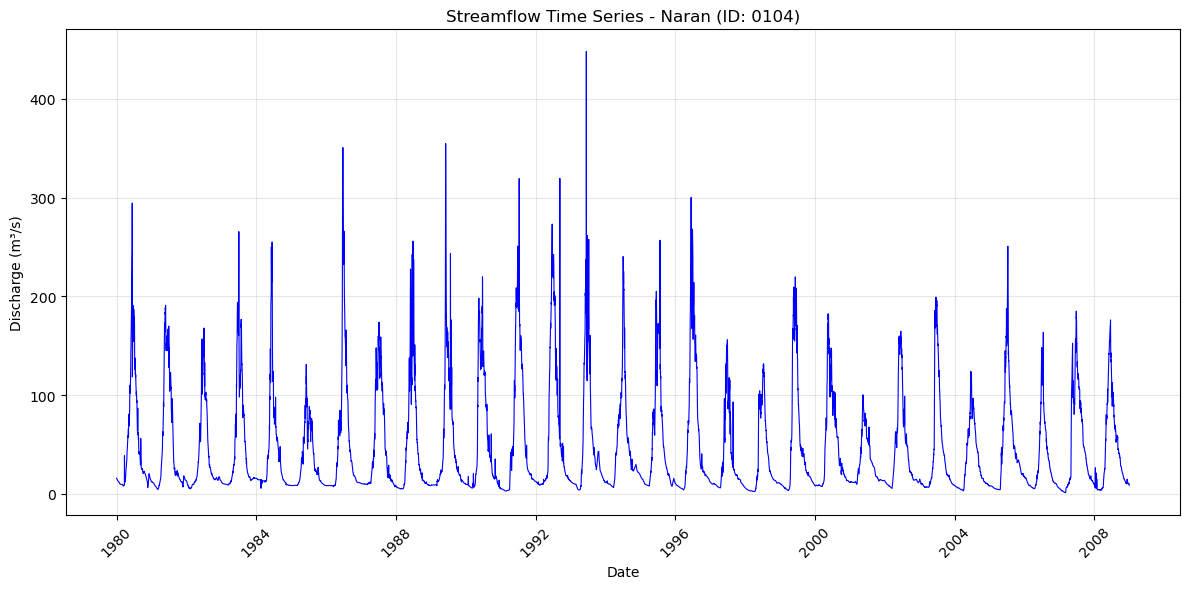

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0104_plot.png

Processing station: G.habib
   Mapped 'G.habib' to ID: 0105
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0105.csv
   Records: 10958
   Valid data: 10558
   Missing data: 400


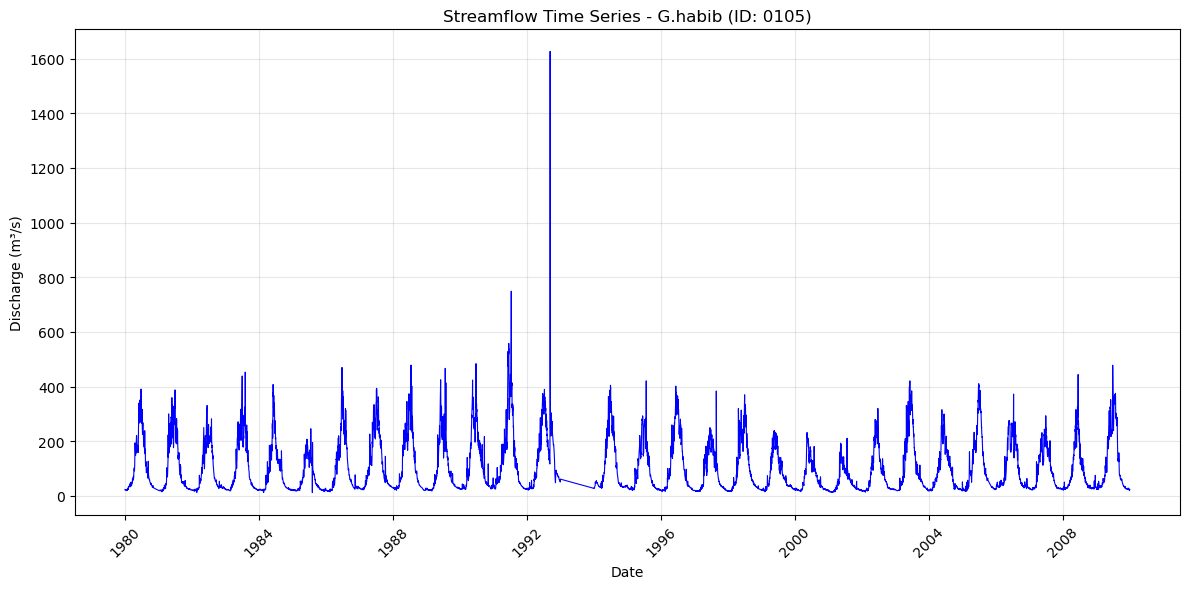

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0105_plot.png

Processing station: Mabad
   ⚠️ Warning: No mapping found for station 'Mabad'. Skipping...

Processing station: kohala
   Mapped 'kohala' to ID: 0109
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0109.csv
   Records: 10958
   Valid data: 5844
   Missing data: 5114


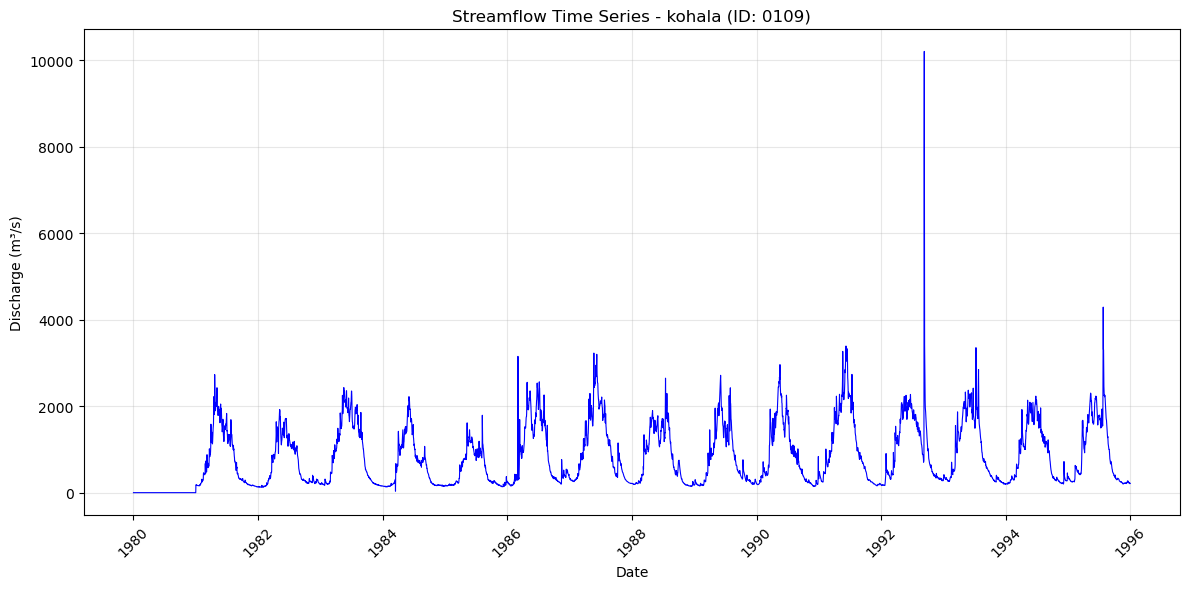

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0109_plot.png

Processing station: Chinari
   Mapped 'Chinari' to ID: 0107
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0107.csv
   Records: 10958
   Valid data: 6179
   Missing data: 4779


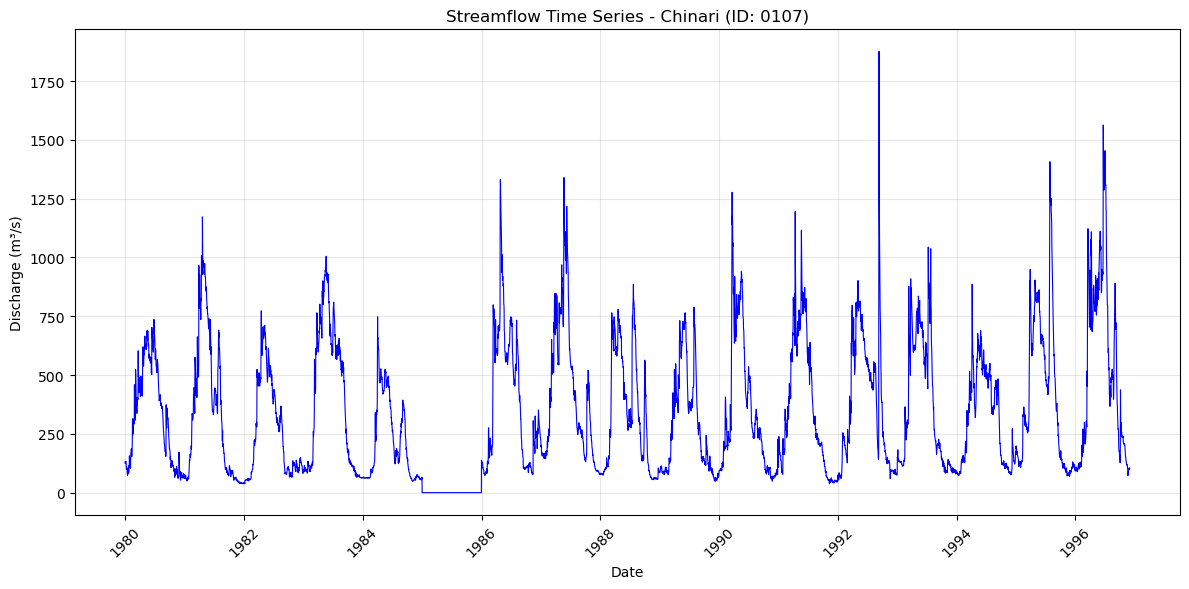

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0107_plot.png

Processing station: AzadPattan
   Mapped 'AzadPattan' to ID: 0110
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0110.csv
   Records: 10958
   Valid data: 10591
   Missing data: 367


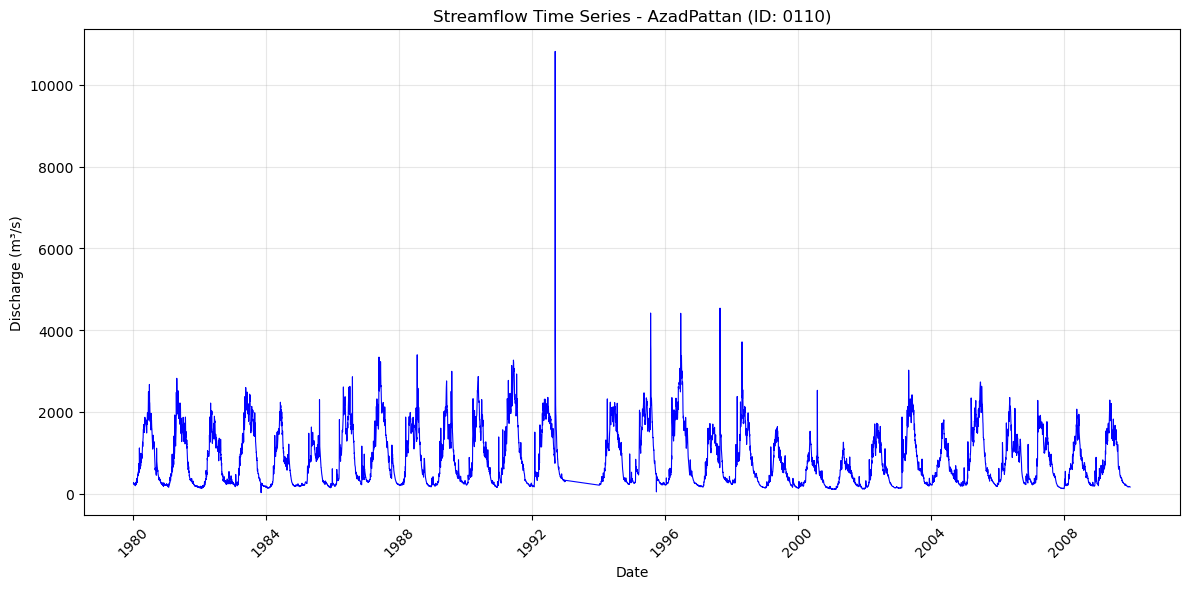

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0110_plot.png

Processing station: Palote
   ⚠️ Warning: No mapping found for station 'Palote'. Skipping...

Processing station: Kotli
   Mapped 'Kotli' to ID: 0111
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0111.csv
   Records: 10958
   Valid data: 10958
   Missing data: 0


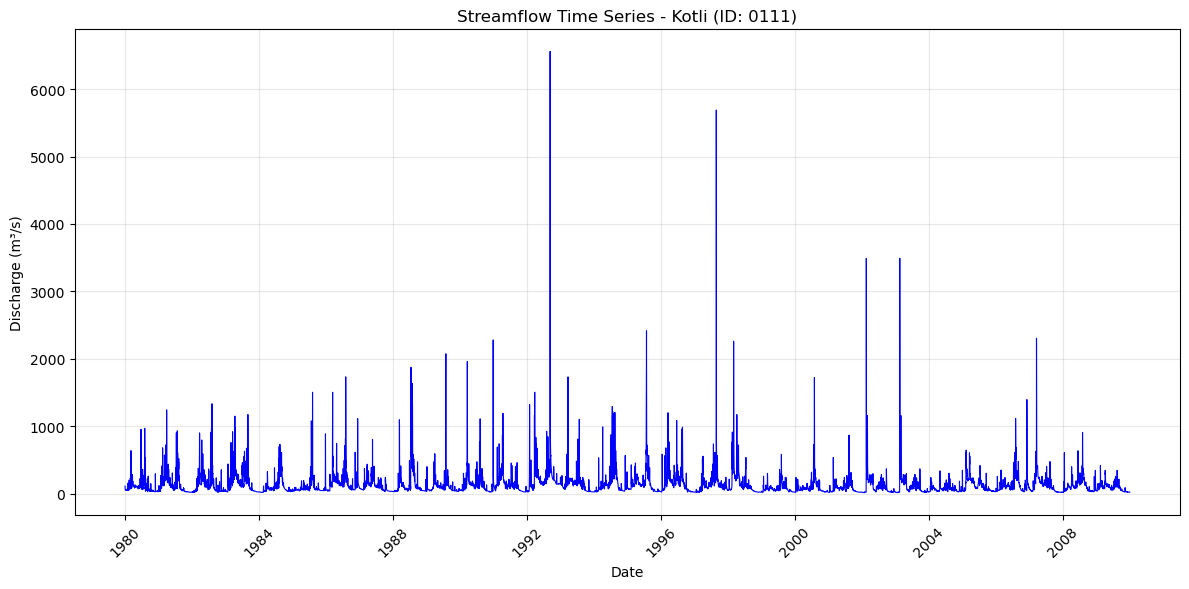

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0111_plot.png

Processing station: Domel
   Mapped 'Domel' to ID: 0108
✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0108.csv
   Records: 10958
   Valid data: 9862
   Missing data: 1096


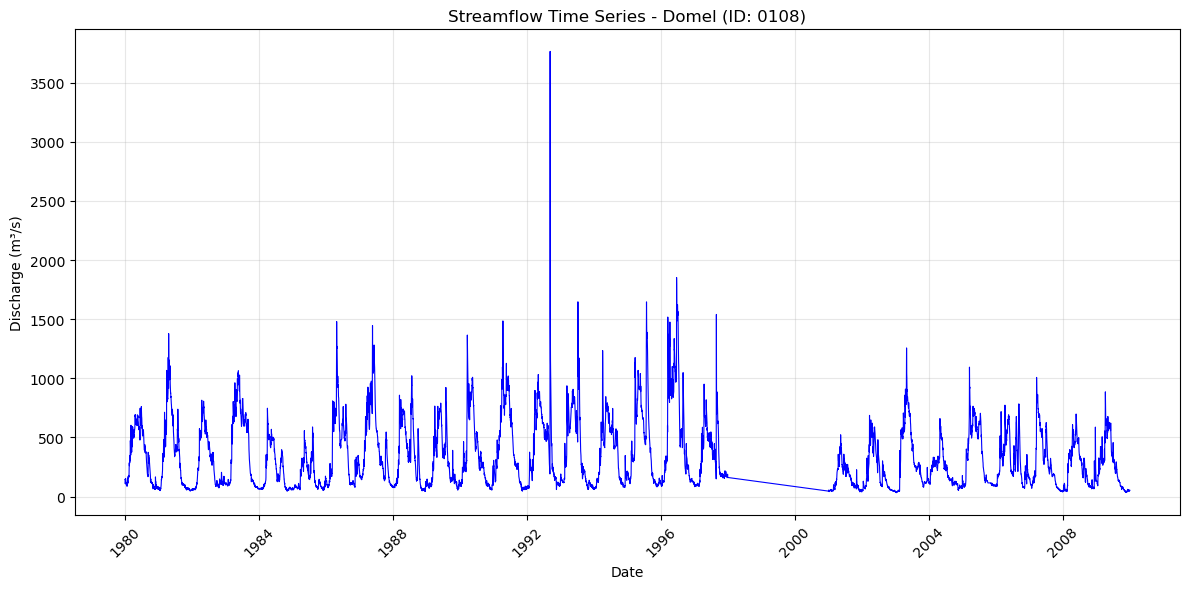

   📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_0108_plot.png

Processing complete!
Successfully processed: 7 stations
Failed: 2 stations
Total stations processed: 7

SUMMARY OF ALL PROCESSED PAKISTAN STATIONS
Station 0104 (Naran       ): 10590/10958 records ( 96.6% complete) | 1980-01-01 to 2009-12-31
Station 0105 (G.habib     ): 10558/10958 records ( 96.3% complete) | 1980-01-01 to 2009-12-31
Station 0109 (Kohala      ):  5844/10958 records ( 53.3% complete) | 1980-01-01 to 2009-12-31
Station 0107 (Chinari     ):  6179/10958 records ( 56.4% complete) | 1980-01-01 to 2009-12-31
Station 0110 (AzadPattan  ): 10591/10958 records ( 96.7% complete) | 1980-01-01 to 2009-12-31
Station 0111 (Kotli       ): 10958/10958 records (100.0% complete) | 1980-01-01 to 2009-12-31
Station 0108 (Domel       ):  9862/10958 records ( 90.0% complete) | 1980-01-01 to 2009-12-31
TOTALS: 64,582 valid records out of 76,706 total records
Overall completeness: 84.2%


In [22]:
# First, explore the Excel file structure
excel_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Pakistan/Data_Mahmood_2016.xlsx"
output_folder = "/home/jberg/OneDrive/Raven_worldwide/01_data/streamflow"

# Explore the file first
if os.path.exists(excel_file):
    print(f"✅ Found Excel file: {excel_file}")
    
    # Explore sheets first
    explore_excel_sheets(excel_file)
    
    print("\n" + "="*60)
    print("PROCESSING SECOND SHEET")
    print("="*60)
    
    # Process the Pakistan streamflow data from the second sheet (index 1)
    pakistan_results = process_pakistan_streamflow(excel_file, output_folder, plot=True, sheet_name=1)
    
    # Create summary
    get_station_summary(pakistan_results)
    
else:
    print(f"❌ Excel file not found: {excel_file}")
    print("Please check the file path and make sure the file exists.")